In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys,os,time

import numpy as np
import skimage.transform
import skimage.measure
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import rasterio

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from sklearn.feature_extraction.image import extract_patches_2d

import cProfile
import re

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

def epitome_small(x,K,N,T,NIT,sc):
    return epitome(x,K,N,T,NIT,sc,0,0)

m = nn.ConstantPad2d((1,0,1,0),0)
def cum_sum(arr, s):
    cumsum = torch.cumsum(torch.cumsum(arr,dim=2),dim=3)
    cumsum = m(cumsum)
    tot = cumsum[:,:,:-s,:-s]-cumsum[:,:,s:,:-s]-cumsum[:,:,:-s,s:]+cumsum[:,:,s:,s:]
    return tot

def to_disp(arr):
    arr_c = arr.cpu().numpy()
    arr_c = np.rollaxis(np.squeeze(arr_c),0,3)
    return arr_c

#learns N x N epitome from T, K x K patches drawn randomly from input image x.
#sc is an optional array of scales to be learnt at, At scale sc[i], T*sc[i]^2 patches are sampled.
#NIT iterations of the E-M algorithm are applied at each scale.
#e,ev = initial epitome mean and variance. If not provided, the mean is initialized
#to the uniform image with some small noise, and the variance is initialized to 1
#p returns an array of probabilities of using each part of the epitome
# the input images should have pixel values between 0 and 1.

def epitome(x,K,N,T,NIT,sc,e,ev):
    #initialize parameters
    xFIN = x
    x = F.interpolate(x,scale_factor=sc)
    x = np.clip(x,0,1)
    _, numDim, SY, SX = x.shape
    TFIN = T
    T = int(np.ceil(TFIN*sc**2))
    NFIN = N
    N = int(np.ceil(sc*NFIN))
    e = torch.zeros((1,numDim,N,N)).to(device)
    ev = torch.ones((1,numDim,N,N)).to(device)
    for i in range(numDim):
        e[:,i,:,:] = x[0,i,:,:].std()*torch.randn(N,N)/100 + x[0,i,:,:].mean() #e = mean of image plus noise
    p = torch.ones((N,N))/N**2
    MINP = 1e-6
    MINV = 1e-2
    #MINP = 1e-30
    #MINV = 1e-6
    
    #allocate space for trace of epitome and start plotting
    etr = torch.zeros((NIT+1,1,numDim,NFIN,NFIN))
    etr[0,:,:,:,:] = F.interpolate(e,size=(NFIN,NFIN))
    etri = 1
    
    plt.figure(figsize=(10,10))
    plt.imshow(to_disp(xFIN[:,:3,:,:]))
    plt.axis('off')
    plt.show()
    plt.close()
                            
    N = int(np.ceil(sc*NFIN))
    e = F.interpolate(e,[N,N])
    e = torch.clamp(e,min=0,max=1)
    ev = F.interpolate(ev,[N,N])
    ev[ev<MINV] = MINV
    #print(p.shape)
    #p = F.interpolate(p.view(1,1,N,N),[N,N])#,mode='constant')
    p /= torch.sum(p)
    x = F.interpolate(xFIN,scale_factor=sc)
    x = torch.clamp(x,min=0,max=1)
    T = int(np.ceil(sc**2*TFIN))
    lP = torch.zeros((N,N),dtype=torch.float).to(device)
    sumP = torch.zeros((N,N),dtype=torch.float).to(device)
    sumPy = torch.zeros((numDim,N,N),dtype=torch.float).to(device)
    sumPy2 = torch.zeros((numDim,N,N),dtype=torch.float).to(device)
    ewrap = torch.zeros((numDim,N+K-1,N+K-1),dtype=torch.float).to(device)
    evwrap = torch.zeros((numDim,N+K-1,N+K-1),dtype=torch.float).to(device)

    SY = x.shape[2]
    SX = x.shape[3]

    ytemp = np.rollaxis(extract_patches_2d(torch.squeeze(x).permute(1,2,0),(K,K),max_patches=T),3,1)
    y = torch.from_numpy(ytemp).float().to(device)

    #perform NIT iterations of EM algorithm
    lPtr = torch.zeros((NIT,1)).float().to(device)
    for nit in range(NIT):
        #glues together borders of e
        ewrap[:,:N,:N] = e;
        ewrap[:,N:,:] = ewrap[:,:K-1,:]
        ewrap[:,:,N:] = ewrap[:,:,:K-1]
        evwrap[:,:N,:N] = ev
        evwrap[:,N:,:] = evwrap[:,:K-1,:]
        evwrap[:,:,N:] = evwrap[:,:,:K-1]
        logevwrap = torch.log(evwrap)
        evwrapi = 1./evwrap

        # E STEP
        sumP[:,:] = 0
        sumPy[:,:,:] = 0
        sumPy2[:,:,:] = 0
        for t in range(T):
            #get current training case
            yc = y[t,:,:,:]
            yct = torch.flip(yc,[1,2])
            yct = torch.unsqueeze(yc,0)
            #print(yct.shape)
            #compute posterior over patch location
            lP[:,:] = torch.log(p)
            tmp1 = torch.squeeze(F.conv2d(torch.unsqueeze(evwrapi,0),yct**2))
            tmp2 = torch.squeeze(F.conv2d(torch.unsqueeze(ewrap*evwrapi,0),yct))
            tmp3 = torch.sum(torch.squeeze(cum_sum(torch.unsqueeze(ewrap**2*evwrapi,0),K)),dim=0)
            tmp4 = torch.sum(torch.squeeze(cum_sum(torch.unsqueeze(logevwrap,0),K)),dim=0)
            lP -= .5*(tmp4+tmp1-2*tmp2+tmp3)
            mxlP = torch.max(lP)
            P = torch.exp(lP-mxlP)+MINP
            nrmP = torch.sum(P)
            P /= nrmP
            lPtr[nit] += mxlP + torch.log(nrmP)

            tmp = P.view(1,1,N,N)
            cp = nn.ConstantPad2d((K-1,K-1,K-1,K-1),0)
            tmp = cp(tmp)
            tmp = torch.squeeze(cum_sum(tmp,K)).to(device)
            tmp[:,:K-1] += tmp[:,N:]
            tmp[:K-1,:] += tmp[N:,:]
            sumP += tmp[:N,:N]
            for i in range(numDim):
                #mean
                tmpP = torch.unsqueeze(torch.unsqueeze(cp(P),0),0)
                #print(P.shape,tmpP.shape,K)
                yctmp = yc[i,:,:].view(1,1,K,K)
                tmp = torch.squeeze(F.conv2d(tmpP,yctmp)).to(device)
                tmp[:,:K-1] += tmp[:,N:]
                tmp[:K-1,:] += tmp[N:,:]
                sumPy[i,:,:] += tmp[:N,:N]

                #variance
                tmp = torch.squeeze(F.conv2d(tmpP,yctmp**2)).to(device)
                tmp[:,:K-1] += tmp[:,N:]
                tmp[:K-1,:] += tmp[N:,:]
                sumPy2[i,:,:] += tmp[:N,:N]

        torch.cuda.empty_cache()
        #M STEP
        p = sumP/torch.sum(sumP)
        for i in range(numDim):
            e[0,i,:,:] = sumPy[i,:,:]/sumP
            ev[0,i,:,:] = sumPy2[i,:,:]/sumP - 2*e[0,i,:,:]*sumPy[i,:,:]/sumP + e[0,i,:,:]**2
        ev = torch.clamp(ev,min=MINV)
        etemp = F.interpolate(e,size=(NFIN,NFIN))
        #print(torch.mode(etemp.view(1,-1)))
        etr[etri,:,:,:] = etemp
        etri += 1

        rows,cols = 1,3
        fig=plt.figure(figsize=(cols*5,rows*5))

        fig.add_subplot(rows, cols, 1)
        plt.axis('off')
        #print(etr.shape)
        td = to_disp(etr[etri-1,:,:3,:,:])
        #print(td.shape,np.min(td),np.max(td))
        plt.imshow(td)
        plt.title(str(N)+'x'+str(N)+' epitome')

        fig.add_subplot(rows, cols, 2)
        plt.axis('off')
        plt.imshow(p,cmap='hot',interpolation='nearest')
        plt.title('mixing proportions')

        fig.add_subplot(rows, cols, 3)
        plt.axis('off')
        tmp = np.sum(np.squeeze(ev.cpu().numpy()),axis=0)
        plt.imshow(tmp,cmap='hot',interpolation='nearest')
        curr_var = np.max(tmp)
        plt.title('variances, max='+str(max(tmp.flatten())))

        plt.show()
        plt.close()
    return e,ev,p,etr

In [7]:
p = pd.read_csv("big_lc_paths.csv", header=None)
paths = p[0].tolist()

def fn(i):
    return paths[i].replace('/','-')[:-7]

naip_tile = rasterio.open("/mnt/blobfuse/esri-naip/"+fn(0).replace('-','/')+".mrf",'r')
naip = naip_tile.read().astype(float)
naip_tile.close()

lc_tile = rasterio.open('/mnt/blobfuse/resampled-lc/'+paths[0],'r')
lc = np.squeeze(lc_tile.read())
lc_tile.close()

trIM = np.zeros((10,naip.shape[1],naip.shape[2]),dtype=float)
trIM[:4,:,:] = naip/255.
for i in range(6):
    trIM[4+i,:,:] = (lc==i)
trIM = np.expand_dims(trIM,axis=0)
trIMtorch = torch.from_numpy(trIM).float().to(device)
    
tsIMtorch = trIMtorch

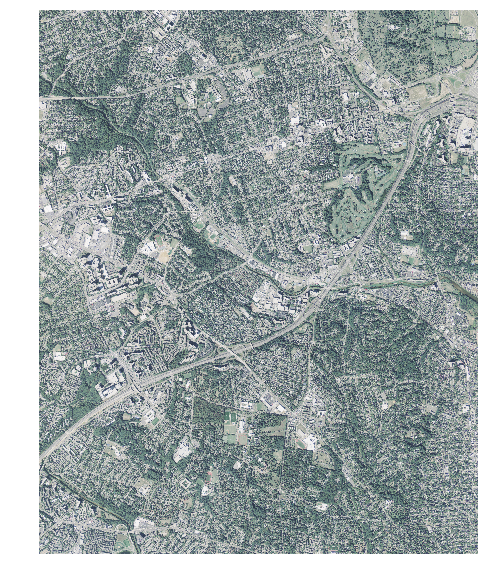

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/feature_extraction/image.py:287: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  indexing_strides = arr[slices].strides


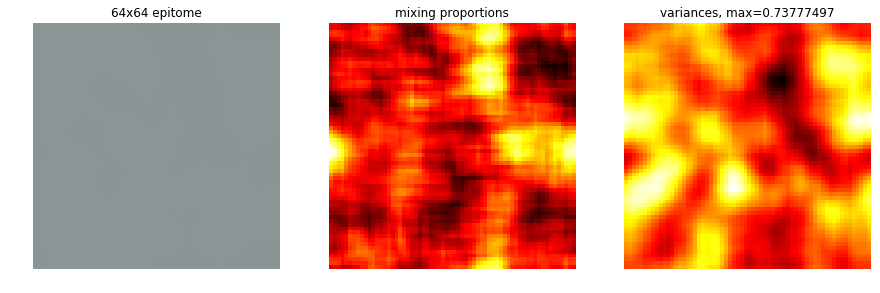

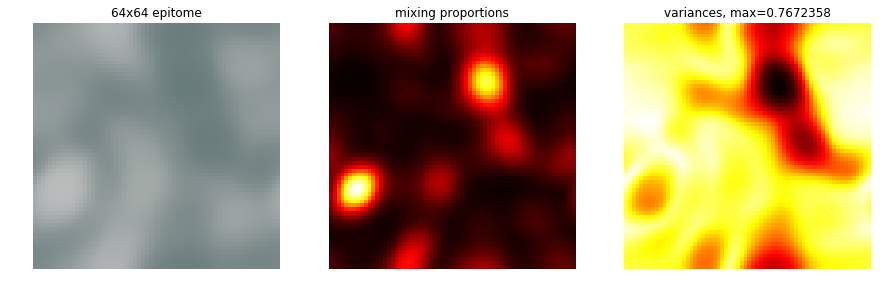

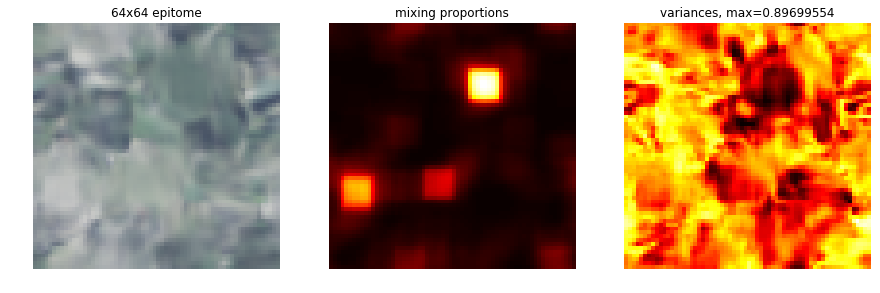

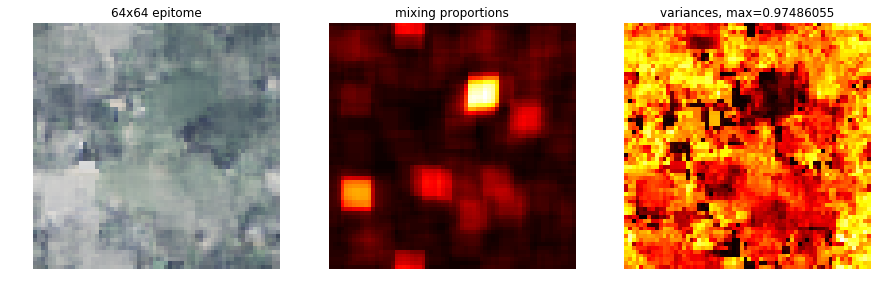

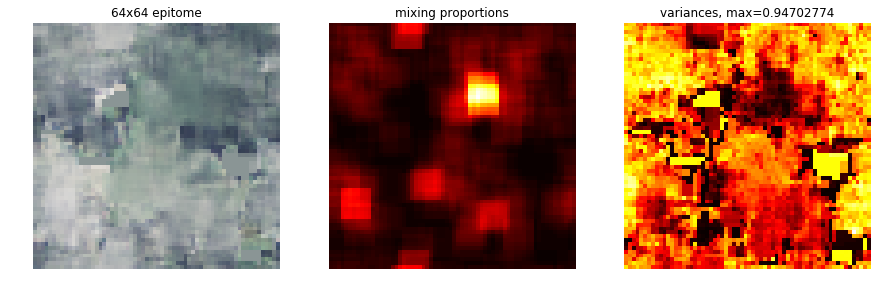

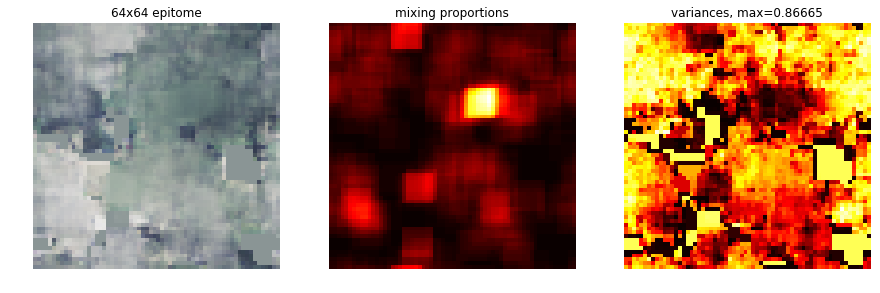

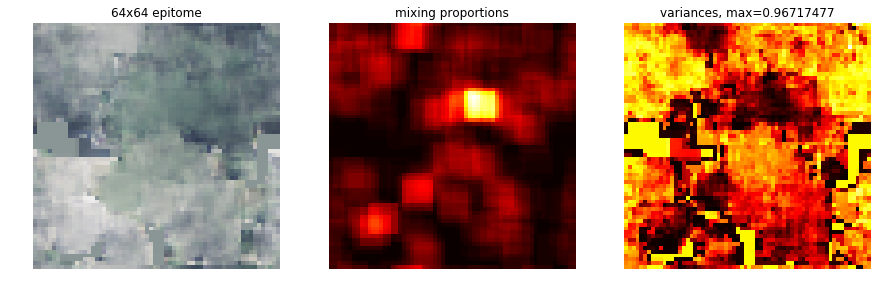

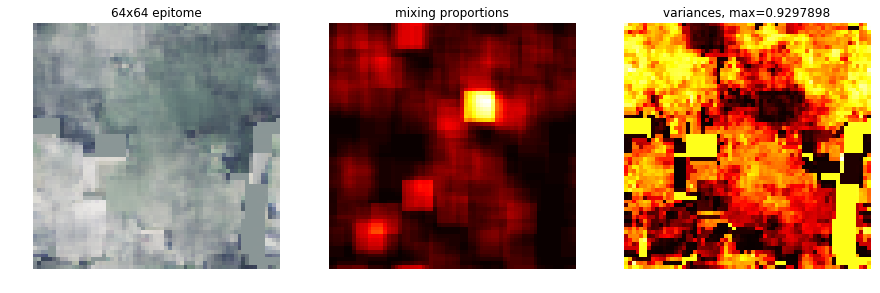

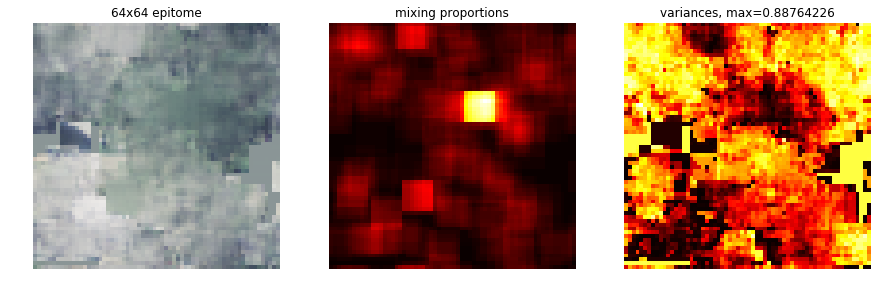

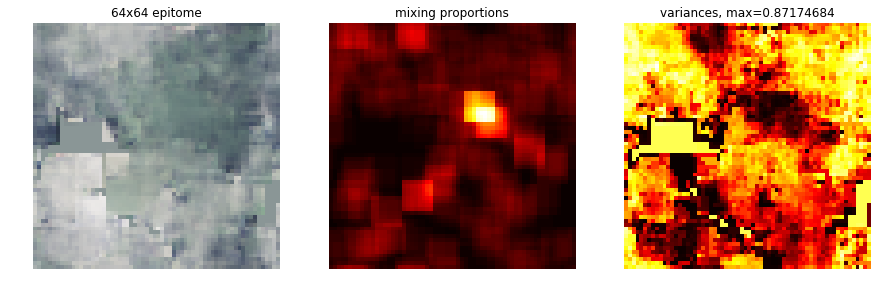

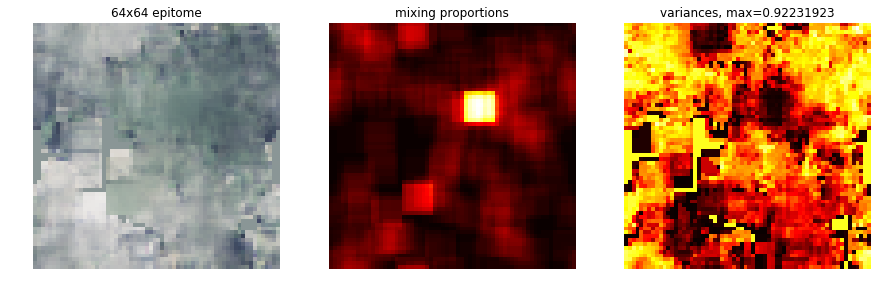

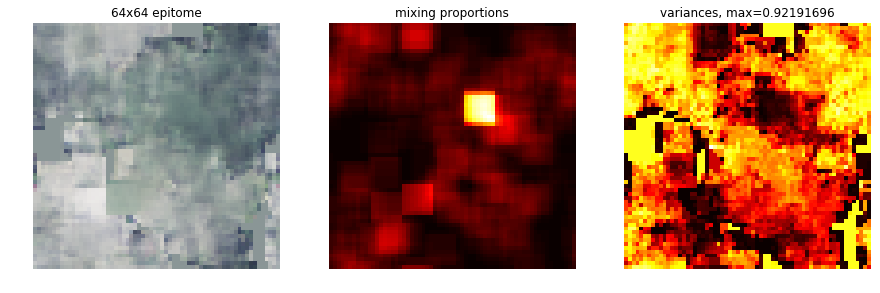

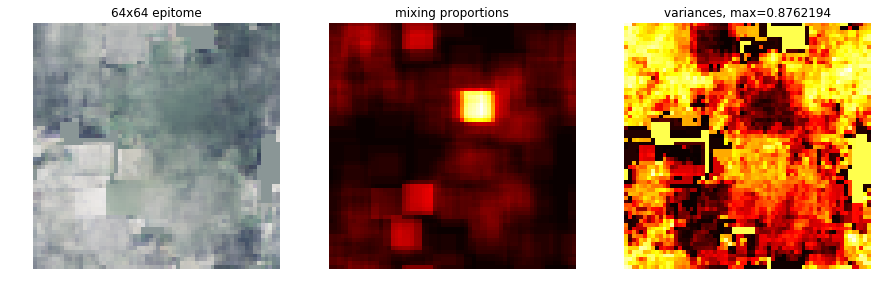

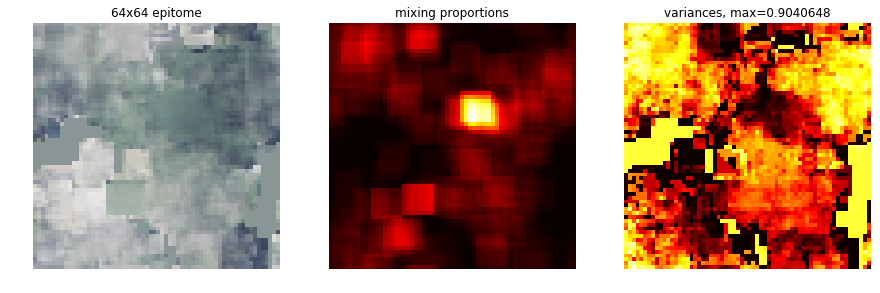

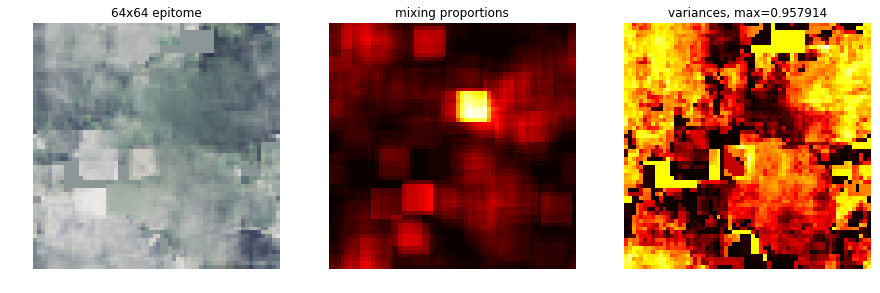

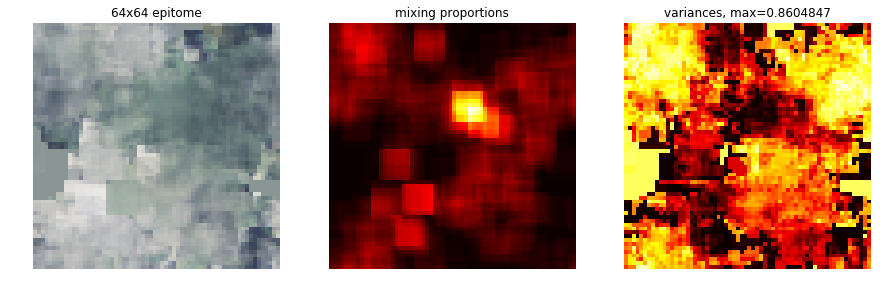

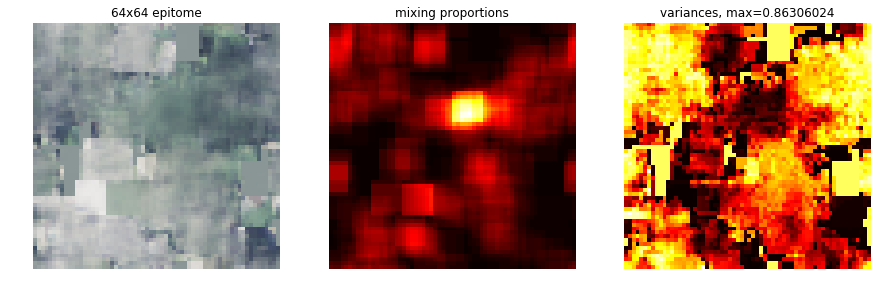

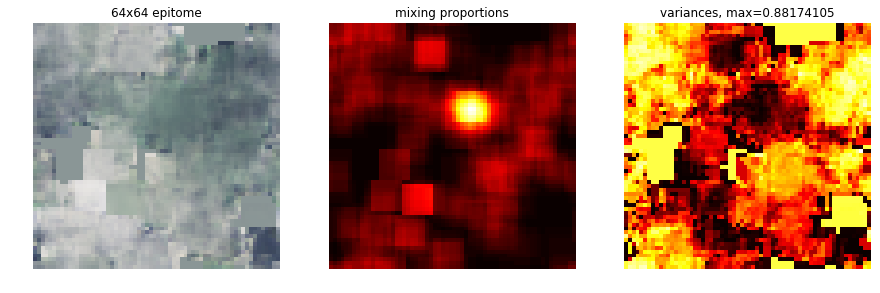

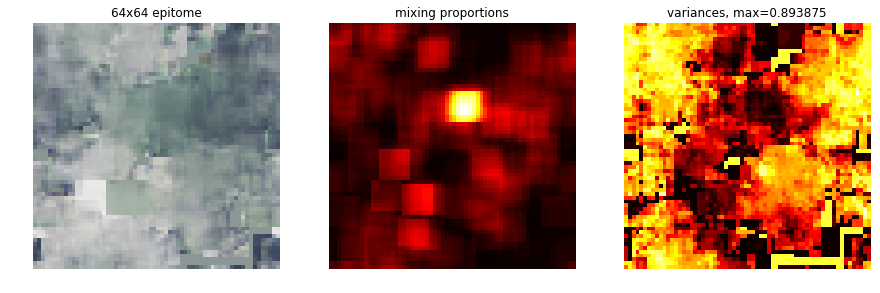

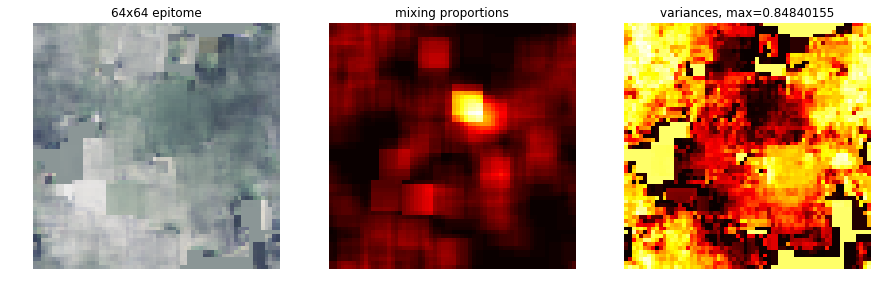

         12587823 function calls (12517741 primitive calls) in 136.264 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       21    0.000    0.000    0.004    0.000 <decorator-gen-10>:1(__call__)
       21    0.000    0.000    0.001    0.000 <decorator-gen-11>:1(__call__)
       21    0.000    0.000    0.001    0.000 <decorator-gen-12>:1(__call__)
      189    0.000    0.000    5.833    0.031 <decorator-gen-9>:1(__call__)
     2107    0.002    0.000    0.005    0.000 <frozen importlib._bootstrap>:995(_handle_fromlist)
       21    0.000    0.000    0.193    0.009 <ipython-input-6-87694f6f6641>:13(to_disp)
        1   60.848   60.848  136.264  136.264 <ipython-input-6-87694f6f6641>:26(epitome)
        1    0.000    0.000  136.264  136.264 <ipython-input-6-87694f6f6641>:3(epitome_small)
    45000    4.869    0.000   11.197    0.000 <ipython-input-6-87694f6f6641>:7(cum_sum)
        1    0.000    0.000  136.264  136.264 <string

    15000    0.114    0.000    0.437    0.000 module.py:62(__init__)
       22    0.000    0.000    0.000    0.000 numeric.py:1407(rollaxis)
      488    0.002    0.000    0.004    0.000 numeric.py:2491(seterr)
      488    0.001    0.000    0.001    0.000 numeric.py:2592(geterr)
      244    0.000    0.000    0.000    0.000 numeric.py:2887(__init__)
      244    0.000    0.000    0.003    0.000 numeric.py:2891(__enter__)
      244    0.001    0.000    0.002    0.000 numeric.py:2896(__exit__)
    28142    0.022    0.000    0.282    0.000 numeric.py:433(asarray)
    12404    0.008    0.000    0.019    0.000 numeric.py:504(asanyarray)
      324    0.000    0.000    0.001    0.000 numerictypes.py:565(obj2sctype)
      564    0.001    0.000    0.001    0.000 numerictypes.py:619(issubclass_)
      282    0.001    0.000    0.002    0.000 numerictypes.py:687(issubdtype)
      324    0.001    0.000    0.001    0.000 numerictypes.py:759(__getitem__)
    15000    0.030    0.000    0.499    0.000

CPU times: user 2min 4s, sys: 19.5 s, total: 2min 24s
Wall time: 2min 16s


In [9]:
%%time
#sc will be changed to a single number
#instead repeatedly call the method to create epitomes at different scales
#e, ev, p, etr = epitome_small(trIMtorch,8,128,3000,30,[.5]) #scale could be [.125 .25 .5 .75]
cProfile.run('e, ev, p, etr = epitome_small(trIMtorch,8,128,3000,20,.5)')
torch.cuda.empty_cache()

In [6]:
#Replaces the epitome (e,ev) of an image by another epitome image (emod)
#keeping the mapping intact. The routine can be used to edit images or to
#preprocess by coloring the image accoring to the image (see the segmentation
#part of the web page for more info). K specifies the patch size to use in 
#mapping inference and SPC defines the patch spacing.

def reconstruct(x,K,e,ev,emod,SPC):
    _,NoCh1,Ny,Nx = x.shape
    NoCh2 = emod.shape[0]
    if NoCh1 == 1:
        temp = x
        x = torch.stack((temp,temp,temp),dim=0)
        #x = torch.zeros((NoCh1,Nx,Ny))
        #x[:,:,0] = temp
        #x[:,:,1] = temp
        #x[:,:,2] = temp
    
    NoCh1,N,Ny = e.shape
    SY = x.shape[2]
    SX = x.shape[3]
    
    ewrap = torch.zeros((NoCh1,N+K-1,N+K-1)).to(device)
    evwrap = torch.zeros((NoCh1,N+K-1,N+K-1)).to(device)
    MINP = 1e-6
    MINV = 1e-2
    
    ewrap[:,:N,:N] = e
    ewrap[:,N:,:] = ewrap[:,:K-1,:]
    ewrap[:,:,N:] = ewrap[:,:,:K-1]
    evwrap[:,:N,:N] = ev
    evwrap[:,N:,:] = evwrap[:,:K-1,:]
    evwrap[:,:,N:] = evwrap[:,:,:K-1]
    logevwrap = torch.log(evwrap)
    evwrapi = 1./evwrap
    tmp3 = torch.sum(torch.squeeze(cum_sum(torch.unsqueeze(ewrap**2*evwrapi,0),K)),dim=0)
    tmp4 = torch.sum(torch.squeeze(cum_sum(torch.unsqueeze(logevwrap,0),K)),dim=0)
    
    #tmp3 = torch.zeros((NoCh1,N,N))
    #tmp4 = torch.zeros((NoCh1,N,N))
    #onemat = np.ones((K,K))
    #for i in range(NoCh1):
        #tmp3[i,:,:] = fftconvolve(evwrap[:,:,i]**2*evwrapi[:,:,i],onemat,mode='valid')
        #tmp4[i,:,:] = fftconvolve(logevwrap[:,:,i],onemat,mode='valid')
        
    emodwrap = torch.zeros((NoCh2,N+K-1,N+K-1))
    emodwrap[:,:N,:N] = emod
    emodwrap[:,N:,:] = emodwrap[:,:K-1,:]
    emodwrap[:,:,N:] = emodwrap[:,:,:K-1]
    
    z = torch.zeros((NoCh2,SY,SX))
    cnt = torch.zeros((SY,SX))
    ixt = 0
    iyt = 0
    for iy in range(0,SY-K+1,SPC):
        for ix in range(0,SX-K+1,SPC):
            #watch for indexing errors
            #yc = x[iy:iy+K-1,ix:ix+K-1,:]
            #print(x.shape)
            yc = x[:,:,iy:iy+K,ix:ix+K]
            #print(x.shape,yc.shape)
            #yct = torch.flip(yc,[2,3])
            #yct = yc[::-1,::-1]
            yct = yc.to(device)
            #print(yc.shape)
            lP = torch.zeros(tmp4.shape).to(device)#[:,:] = 0
            #print(evwrapi.shape,ewrap.shape,evwrap.shape,yct.shape)
            tmp1 = torch.squeeze(F.conv2d(torch.unsqueeze(evwrapi,0),yct**2))
            tmp2 = torch.squeeze(F.conv2d(torch.unsqueeze(ewrap*evwrap,0),yct))
            lP += -.5*(tmp4+tmp1-2*tmp2+tmp3)
            #for i in range(NoCh1):
                #tmp1 = fftconvolve(evwrapi[:,:,i],yct[:,:,i]**2,mode='valid')
                #tmp2 = fftconvolve(ewrap[:,:,i]*evwrap[:,:,i],yct[:,:,i],mode='valid')
                #lP += -.5*(tmp4[:,:,i]+tmp1-2*tmp2+tmp3[:,:,i])
            mxlP = torch.max(lP)
            P = torch.exp(lP-mxlP)+MINP
            nrmP = torch.sum(P)
            P /= nrmP
            mxp,mxpj = torch.max(P,dim=1)#,torch.argmax(P,dim=1)
            mxp, mxpi = torch.max(mxp),torch.argmax(mxp)
            mxpj = mxpj[mxpi]
            #watch for indexing errors
            newp = emodwrap[:,mxpi:mxpi+K-1,mxpj:mxpj+K-1]
            oldp = ewrap[:,mxpi:mxpi+K-1,mxpj:mxpj+K-1]
            z[:,iy:iy+K-1,ix:ix+K-1] += newp 
            cnt[iy:iy+K-1,ix:ix+K-1] += 1
            
            ixt = ix
            iyt = iy
    z = z[:,:iyt+K-1,:ixt+K-1]
    cnt = cnt[:iyt+K-1,:ixt+K-1]
    for i in range(NoCh2):
        z[i,:,:] /= cnt
    
    return z

In [7]:
%%time
z = reconstruct(tsIMtorch[:,:4,:,:],17,e[0,:4,:,:],ev[0,:4,:,:],e[0,4:10,:,:],3)

CPU times: user 1h 54min 10s, sys: 32min 1s, total: 2h 26min 12s
Wall time: 2h 26min 9s


In [27]:
print(trIMtorch.shape)
temp = np.rollaxis(extract_patches_2d(torch.squeeze(trIMtorch).permute(1,2,0),(8,8),max_patches=1000),3,1)
pp = torch.from_numpy(temp).float().to(device)
print(pp.shape)

torch.Size([1, 10, 7662, 6185])
torch.Size([1000, 10, 8, 8])


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/feature_extraction/image.py:287: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  indexing_strides = arr[slices].strides


In [6]:
tt = torch.Tensor([1e-30])

In [7]:
tt

tensor([1.0000e-30])